# Modules

In [2]:
import sys
import os
import time
if sys.version_info.major > 2:
    from functools import reduce

import numpy as np

from PIL import Image
from matplotlib import pyplot as plt
%matplotlib inline
import scipy.misc

import tensorflow as tf
from tensorflow.python.framework import graph_util

# Model

In [38]:
# Load Model Function
def load_pb(pb_path, *, graph=None, name="", input_map=None):
    _, ext = os.path.splitext(pb_path)
    graph_def = tf.GraphDef()
    with tf.gfile.GFile(pb_path, "rb") as fid:
        graph_def.ParseFromString(fid.read())
    if graph is not None:
        with graph.as_default():
            tf.import_graph_def(graph_def, name=name, input_map=input_map)
        return
    return graph_def

# Itil Functions
def tensor_name(name, scope=None):
    if scope:
        return "{}/{}:0".format(scope, name)
    return "{}:0".format(name)

def gram_matrix(activation, name="Gram_Matrix"):
    """
    args
    ====
    - activation: 1 by W by H by C tensor.
    """
    with tf.name_scope(name):
        with tf.name_scope("preprocess"):
            activation = tf.transpose(activation, perm=[3, 0, 1, 2])
            M = reduce(lambda acc, x: acc*x, activation.shape.as_list()[2:], 1)
            F = tf.reshape(activation, shape=[-1, M], name="F")
        G = tf.matmul(F, tf.transpose(F), name="gram_matrix")
    return G

In [35]:
# load vgg19 into graph
vgg_net = tf.Graph()
load_pb("./vgg19.pb", graph=vgg_net)

In [36]:
content_layer_name = "conv4_2/Relu"
style_layer_names = ["conv1_1/Relu", "conv2_1/Relu", 
                     "conv3_1/Relu", "conv4_1/Relu", "conv5_1/Relu"]
style_weights = (lambda arr: arr/arr.sum())(np.array([1, 1, 1, 1, 1], dtype=np.float32))
assert len(style_layer_names) == len(style_weights), \
    "the number of layers and weights do no match"

In [47]:
alpha = 1e3
beta_tv = 8e11
use_smooth_tv = False
save_path = "./nn_art"

In [43]:
artist_net = tf.Graph()
with artist_net.as_default():
    # setup hyper parameters
    tf_alpha = tf.constant(alpha, dtype=tf.float32, name="alpha")
    tf_beta_tv = tf.constant(beta_tv, dtype=tf.float32, name="beta_tv")
    tf_style_weights = [tf.constant(w, dtype=tf.float32, name="style_weight{}".format(i))
                        for i, w in enumerate(style_weights, 1)]
    
    # the output image we want
    # Note that the output image will be noramlized to [0, 1]
    tf_output_image = tf.Variable(np.random.randn(1, 224, 224, 3), 
                                  dtype=tf.float32,
                                  name="output_image")
    with tf.name_scope("content_image"):
        tf_content_image = tf.placeholder(tf.float32,
                                          shape=[1, 224, 224, 3],
                                          name="image")
    with tf.name_scope("style_image"):
        tf_style_image = tf.placeholder(tf.float32,
                                        shape=[1, 224, 224, 3],
                                        name="image")
    
    # import three vgg graphs in to artist graph
    # one for constructed image, one for content representation, one for style
    ## content image
    sub_vgg_graph_def = graph_util.extract_sub_graph(vgg_net.as_graph_def(),
                                                     [content_layer_name])
    tf.import_graph_def(sub_vgg_graph_def, 
                        name="vgg_content",
                        input_map={"input_rgb": tf_content_image})
    ## style image
    sub_vgg_graph_def = graph_util.extract_sub_graph(vgg_net.as_graph_def(),
                                                     style_layer_names)
    tf.import_graph_def(sub_vgg_graph_def,
                        name="vgg_style",
                        input_map={"input_rgb": tf_style_image})
    
    ## output image
    all_names = [content_layer_name] + style_layer_names
    sub_vgg_graph_def = graph_util.extract_sub_graph(vgg_net.as_graph_def(),
                                                     all_names)
    tf.import_graph_def(sub_vgg_graph_def,
                        name="vgg_fit",
                        input_map={"input_rgb": tf_output_image})
    del sub_vgg_graph_def
    
    ## loss
    with tf.name_scope("loss"):
        ## content loss
        with tf.name_scope("content_loss"):
            content_layer = artist_net.get_tensor_by_name(tensor_name(content_layer_name, 
                                                                      "vgg_content"))
            content_act = artist_net.get_tensor_by_name(tensor_name(content_layer_name,
                                                                     "vgg_fit"))
            with tf.control_dependencies([content_layer, content_act]):
                loss_content = tf.multiply(0.5,
                                           tf.reduce_sum(tf.squared_difference(content_layer, content_act)),
                                           name="square_sum_loss")
        ## style loss
        loss_style = None
        with tf.name_scope("style_loss"):
            for weight, name in zip(tf_style_weights, style_layer_names):
                style_layer = artist_net.get_tensor_by_name(tensor_name(name, "vgg_style"))
                G1 = gram_matrix(style_layer, "GramMatrix1_{}".format(name))
                style_act = artist_net.get_tensor_by_name(tensor_name(name, "vgg_fit"))
                G2 = gram_matrix(style_act, "GramMatrix2_{}".format(name))
                shape = style_layer.shape.as_list()
                N = shape[3]
                M = shape[1]*shape[2]
                with tf.control_dependencies([style_layer, style_act]):
                    dloss = tf.multiply(weight/tf.constant((2*N*M)**2, dtype=tf.float32),
                                        tf.reduce_sum(tf.squared_difference(G1, G2)),
                                        name="loss_{}".format(name))
                if loss_style is None:
                    loss_style = dloss
                else:
                    loss_style += dloss
        with tf.name_scope("TV_loss"):
            if use_smooth_tv:
                loss_tv = TV_loss(tf_output_image)[0]
            else:
                loss_tv = tf.image.total_variation(tf_output_image, name="loss")[0]
        ## total loss
        with tf.control_dependencies([loss_content, loss_tv, loss_style]):
            loss = tf.reduce_sum([tf_alpha*loss_content,
                                  tf_beta_tv*loss_tv,
                                  loss_style],
                                  name="total_loss")
            
    with tf.name_scope("optimization"):
        train_op = tf.train.AdamOptimizer(20.0).minimize(loss)
    saver = tf.train.Saver()

# Training

In [12]:
def read_image(path, size=None, swap=False):
    """ Read image, resize it and swap channel if needed """
    pil_image = Image.open(path).convert("RGB")
    if size:
        pil_image = pil_image.resize(size)
        pil_image = pil_image.rotate(-90)
    np_image = np.array(pil_image)
    if swap:
        np_image = np_image[:,:,[2,1,0]]
    return np_image

In [54]:
# Training
num_iteration = 1000
log_every_step = 100

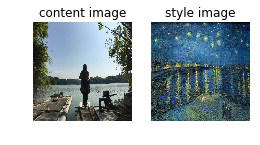

In [68]:
content_image_path = "./My_Picture3.jpg"
style_image_path = "./style.jpg"
content_image = read_image(content_image_path, (224, 224), swap=False)
style_image = read_image(style_image_path, (224, 224), swap=False)

plt.subplot(1, 3, 1)
plt.title("content image")
plt.axis("off")
plt.imshow(content_image)

plt.subplot(1, 3, 2)
plt.title("style image")
plt.axis("off")
plt.imshow(style_image)

All variables inititialized......
Initial losses: 8.9156e+19
  Content loss: 1.16282e+16
  Style loss: 7.7258e+19
  TV loss: 337331.0
  alpha: 1000.0
  beta (TV):  8e+11
--------------------------------------------------
step: 100
totol loss: 8.99913e+18
content loss: 3.59588e+15
style loss: 2.22901e+18
TV loss: 3.9678e+06
mean duration: 2.7674 sec
--------------------------------------------------
step: 200
totol loss: 7.129e+18
content loss: 3.18187e+15
style loss: 1.27651e+18
TV loss: 3.33828e+06
mean duration: 2.7762 sec
--------------------------------------------------
step: 300
totol loss: 7.76594e+18
content loss: 3.23568e+15
style loss: 1.43769e+18
TV loss: 3.86571e+06
mean duration: 2.7906 sec
--------------------------------------------------
step: 400
totol loss: 7.76809e+18
content loss: 3.31231e+15
style loss: 1.57702e+18
TV loss: 3.59845e+06
mean duration: 2.7859 sec
--------------------------------------------------
step: 500
totol loss: 7.61746e+18
content loss: 3.1343

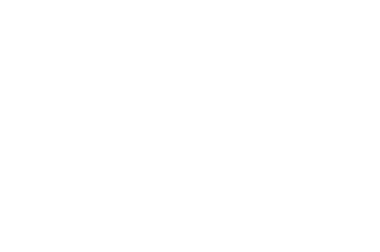

In [69]:
log_file = sys.stdout
try:
    with tf.Session(graph=artist_net) as sess:
        tf.global_variables_initializer().run()
        print("All variables inititialized......", 
              file=log_file, 
              flush=True)
        feed_dict = {tf_content_image: content_image[None,:],
                     tf_style_image: style_image[None,:]}
        tl, cl, sl, tvl, alpha_, beta_ = sess.run([loss, loss_content,
                                                   loss_style, loss_tv, 
                                                   tf_alpha, tf_beta_tv], 
                                      feed_dict=feed_dict)
        print("Initial losses:", tl, file=log_file, flush=True)
        print("  Content loss:", cl, file=log_file, flush=True)
        print("  Style loss:", sl, file=log_file, flush=True)
        print("  TV loss:", tvl, file=log_file, flush=True)
        print("  alpha:", alpha_, file=log_file, flush=True)
        print("  beta (TV): ", beta_, file=log_file, flush=True)
        print("--------------------------------------------------")
        durations = []
        for step in range(1, num_iteration+1):
            start_time = time.time()
            l, cl, sl, tvl, _ = sess.run([loss, loss_content, loss_style, 
                                          loss_tv, train_op], 
                                          feed_dict=feed_dict)
            end_time = time.time()
            durations.append(end_time-start_time)
            if step % log_every_step == 0:
                print("step:", step, file=log_file, flush=True)
                print("totol loss:", l, file=log_file, flush=True)
                print("content loss:", cl, file=log_file, flush=True)
                print("style loss:", sl, file=log_file, flush=True)
                print("TV loss:", tvl, file=log_file, flush=True)
                print("mean duration: {:.4f} sec".format(np.mean(durations)),
                      file=log_file, flush=True)
                print("--------------------------------------------------")
                if np.isnan(l):
                    print("nan detected, breaking training loop", 
                          file=log_file, 
                          flush=True)
                    break
                chkp_path = saver.save(sess, save_path, step)
                durations = []
                
                # Save image for every 100 iterations
                out_images_tmp = tf_output_image.eval()
                out_images_tmp = np.clip(out_images_tmp[0], 0, 200).astype(np.uint8)
                plt.axis('off')
                scipy.misc.imsave("./transformed_image_numIter" + str(step) + ".png", out_images_tmp)

        out_images = tf_output_image.eval()
        
except BaseException as e:
    print("interrupted...", file=log_file, flush=True)
    print(type(e), file=log_file, flush=True)
    print(e, file=log_file, flush=True)
finally:
    print("fitting done", file=log_file, flush=True)
    if not log_file is sys.stdout:
        print("closing log file")
        log_file.close()

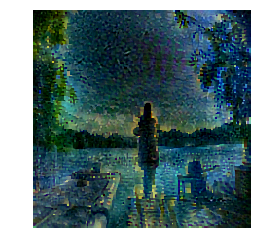

In [70]:
# Postprocess for smoothing
out_image = np.clip(out_images[0], 0, 200).astype(np.uint8)
plt.axis('off')
plt.imshow(out_image)

scipy.misc.imsave('./transformed_image.png', out_image)

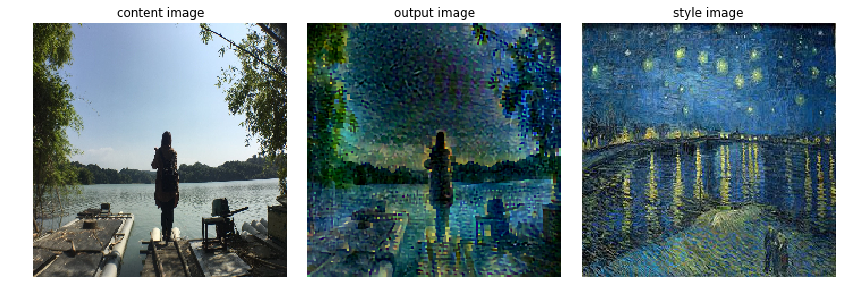

In [94]:
plt.subplot(1, 3, 1)
plt.title("content image")
plt.axis("off")
plt.imshow(content_image)

plt.subplot(1, 3, 2)
plt.title("output image")
plt.axis("off")
plt.imshow(out_image)
fig = plt.gcf()

plt.subplot(1, 3, 3)
plt.title("style image")
plt.axis("off")
plt.imshow(style_image)

fig.set_size_inches((12, 4))
fig.tight_layout(w_pad=-2)

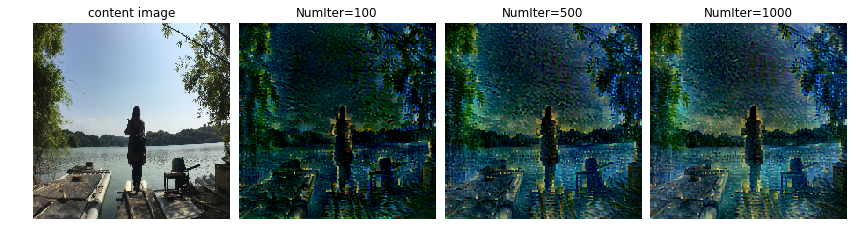

In [92]:
output_image_path0 = "./transformed_image_numIter100.png"
output_image_path1 = "./transformed_image_numIter500.png"
output_image_path2 = "./transformed_image_numIter1000.png"
output_image0 = read_image(output_image_path0, (224, 224), swap=False)
output_image1 = read_image(output_image_path1, (224, 224), swap=False)
output_image2 = read_image(output_image_path2, (224, 224), swap=False)

plt.subplot(1, 4, 1)
plt.title("content image")
plt.axis("off")
plt.imshow(content_image)

plt.subplot(1, 4, 2)
plt.title("NumIter=100")
plt.axis("off")
plt.imshow(output_image0)

plt.subplot(1, 4, 3)
plt.title("NumIter=500")
plt.axis("off")
plt.imshow(output_image1)
fig = plt.gcf()

plt.subplot(1, 4, 4)
plt.title("NumIter=1000")
plt.axis("off")
plt.imshow(output_image2)

fig.set_size_inches((12, 4))
fig.tight_layout(w_pad=-2)

"""
看起來隨著迭代次數增加，圖片的細節(對比、亮度...等)會越來越呈現出來，
尤其湖的部分看起來較精緻了，畫質上顆粒也會趨於平緩。
"""